In [21]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io

import os
import time

## 超参数设置

In [23]:
domain = (-1, 1, -1, 1)
xmin, xmax, ymin, ymax = domain
mlp_layers = [2] + [40]*8 + [2]
mlp_layers_k = [2] + [20]*3 + [1]
n_iters = 200000
learning_rate = 1e-3
gamma = 0.6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

## 数据集生成

In [24]:
data = io.loadmat('example1_slt_512.mat')
dx_comp = data['dx_comp']
dx_pml = data['dx_pml']
dy_comp = data['dy_comp']
dy_pml = data['dy_pml']
height = data['height']
width = data['width']
k0 = data['k0']
m = data['m']
n = data['n']
uf = data['uf'].T
x = data['x']
y = data['y']

x.shape

(1, 1537)

In [25]:
class DatasetHelmholtz:
    def __init__(self, domain):
        self.domain = domain
    
    def train_data(self, N=5000, verbose=None):
        xmin, xmax, ymin, ymax = self.domain
        xx, yy = np.meshgrid(x[0, 256:-256], y[0, 256:-256])
        X_res = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
        f_res_u, f_res_v = self.func_res(X_res)
        uv_data = uf[256:-256, 256:-256].reshape(-1, 1)
        u_data = uv_data.real
        v_data = uv_data.imag
        
        idx = np.random.randint(0,1025*1025,N)
        return X_res[idx], f_res_u[idx], f_res_v[idx], u_data[idx], v_data[idx]
    
    def func_res(self, X_res):
        a = np.pi / (2 * k0.item())
        f_res_u = np.empty(X_res.shape[0])
        
        for i in range(X_res.shape[0]):
            x1, x2 = X_res[i]
            d = ((x1 - 0.5)**2 + (x2 - 0)**2) ** 0.5
            
            if d < 0.5:
                f_res_u[i] = 1 / (np.sqrt(np.pi) * a) * np.exp(- (d/a) ** 2)
            else:
                f_res_u[i] = 0
        f_res_u = f_res_u.reshape(-1, 1)
        
        f_res_v = np.zeros_like(f_res_u)
        return f_res_u, f_res_v
    

dataset = DatasetHelmholtz(domain)
X_res, f_res_u, f_res_v, u_data, v_data = dataset.train_data()
print(X_res.shape, f_res_u.shape, f_res_v.shape, u_data.shape, v_data.shape)

(5000, 2) (5000, 1) (5000, 1) (5000, 1) (5000, 1)


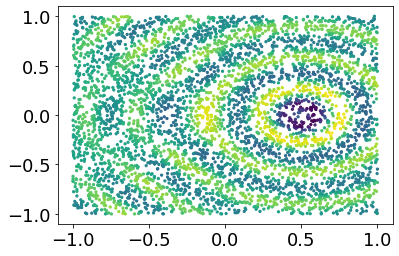

In [26]:
plt.scatter(X_res[:, 0], X_res[:, 1], c=u_data, s=5)

## PINN主干网络

In [27]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            self.model.add_module(f'fc{i+1}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            self.model.add_module(f'act{i+1}', nn.Tanh())
        self.model.add_module(f'fc{len(mlp_layers)-1})', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
    
    def forward(self, X):
        return self.model(X)
    
    
mlp = MLP(mlp_layers)
mlp_k = MLP(mlp_layers_k)
mlp.model

Sequential(
  (fc1): Linear(in_features=2, out_features=40, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=40, out_features=40, bias=True)
  (act3): Tanh()
  (fc4): Linear(in_features=40, out_features=40, bias=True)
  (act4): Tanh()
  (fc5): Linear(in_features=40, out_features=40, bias=True)
  (act5): Tanh()
  (fc6): Linear(in_features=40, out_features=40, bias=True)
  (act6): Tanh()
  (fc7): Linear(in_features=40, out_features=40, bias=True)
  (act7): Tanh()
  (fc8): Linear(in_features=40, out_features=40, bias=True)
  (act8): Tanh()
  (fc9)): Linear(in_features=40, out_features=2, bias=False)
)

## PINN模型

In [28]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [29]:
class PINNHelmholtz(nn.Module):
    def __init__(self, backbone, nn_k):
        super(PINNHelmholtz, self).__init__()
        self.backbone = backbone
        self.nn_k = nn_k
        
        self.a = (20 - 20/1.5)/2
        self.b = (20 - 20/1.5)/2 + 20/1.5
    
    def forward(self, X_res, f_res_u, f_res_v, u_data, v_data):
        f_res_u_pred, f_res_v_pred = self.net_f(X_res)
        uv_pred = self.net_u(X_res)
        u_pred = uv_pred[:, [0]]
        v_pred = uv_pred[:, [1]]

        loss_res_u = torch.mean((f_res_u_pred - f_res_u) ** 2)
        loss_res_v = torch.mean((f_res_v_pred - f_res_v) ** 2)
        loss_data_u = torch.mean((u_pred - u_data) ** 2)
        loss_data_v = torch.mean((v_pred - v_data) ** 2)
        return loss_res_u, loss_res_v, loss_data_u, loss_data_v
    
    def net_u(self, X):
        return self.backbone(X) * 5e-3
    
    def net_k(self, X):
        return self.nn_k(X)
        # return self.a * torch.tanh( self.nn_k(X) ) + self.b
    
    def net_f(self, X):
        X.requires_grad_(True)
        uv = self.net_u(X)
        u = uv[:, [0]]
        v = uv[:, [1]]
        
        # 求实部u的梯度
        grad_u = grad(u, X)[0]
        u_x = grad_u[:, [0]]
        u_y = grad_u[:, [1]]
        u_xx = grad(u_x, X)[0][:, [0]]
        u_yy = grad(u_y, X)[0][:, [1]]
        
        # 求虚部v的梯度
        grad_v = grad(v, X)[0]
        v_x = grad_v[:, [0]]
        v_y = grad_v[:, [1]]
        v_xx = grad(v_x, X)[0][:, [0]]
        v_yy = grad(v_y, X)[0][:, [1]]
        
        k = self.net_k(X)
        
        f_res_u_pred = -(u_xx + u_yy) - k**2 * u
        f_res_v_pred = -(v_xx + v_yy) - k**2 * v
        
        return f_res_u_pred, f_res_v_pred
    

pinn = PINNHelmholtz(mlp,mlp_k)

## Adam训练

In [30]:
# 训练
dataset = DatasetHelmholtz(domain)
X_res, f_res_u, f_res_v, u_data, v_data = dataset.train_data()
X_res = torch.from_numpy(X_res).float().to(device)
f_res_u = torch.from_numpy(f_res_u).float().to(device)
f_res_v = torch.from_numpy(f_res_v).float().to(device)
u_data = torch.from_numpy(u_data).float().to(device)
v_data = torch.from_numpy(v_data).float().to(device)

backbone = MLP(mlp_layers)
nn_k = MLP(mlp_layers_k)
pinn = PINNHelmholtz(backbone, nn_k)
pinn = pinn.to(device)

optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=learning_rate)
optimizer_adam_k = optim.Adam(pinn.nn_k.parameters(), lr=learning_rate)
# optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, 
# threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False
lr_sche = ReduceLROnPlateau(optimizer_adam, mode='min', factor=gamma, verbose=True)
lr_sche_k = ReduceLROnPlateau(optimizer_adam_k, mode='min', factor=gamma, verbose=True)

logger = {
    "loss": [],
    "loss_res_u": [],
    "loss_res_v": [],
    "loss_data_u": [],
    "loss_data_v": [],
    "iter": []
}
with open(train_info_path + 'train_info.txt', 'w') as f:
    f.write('Training by Adam:\n')
start_time = time.time()

for it in range(n_iters):
    pinn.zero_grad()
    loss_res_u, loss_res_v, loss_data_u, loss_data_v = pinn(X_res, f_res_u, f_res_v, u_data, v_data)
    loss = 1e4 * (1*(loss_res_u + loss_res_v) + 
                  1e4*(loss_data_u + loss_data_v))
    loss.backward()
    optimizer_adam.step()
    optimizer_adam_k.step()
    
    # 保存训练信息 -------
    logger["loss"].append(loss.item())
    logger["loss_res_u"].append(loss_res_u.item())
    logger["loss_res_v"].append(loss_res_v.item())
    logger["loss_data_u"].append(loss_data_u.item())
    logger["loss_data_v"].append(loss_data_v.item())
    logger["iter"].append(it + 1)
    
    if (it + 1) % 100 == 0:  # 打印训练信息 -------
        info = f'Iter # {it+1:4d}/{n_iters}\ttime:{time.time()-start_time:.1f}\t' + f'loss:{loss.item():.2e}, loss_r_u:{loss_res_u.item():.2e}, loss_r_v:{loss_res_v.item():.2e}, loss_d_u:{loss_data_u.item():.2e}, loss_d_v:{loss_data_v.item():.2e}'
        with open(train_info_path + 'train_info.txt', 'a') as f:
            f.write(info + '\n')
        print(info)
        
    if (it + 1) % 100 == 0:  # 学习率衰减 -------
        lr_sche.step(loss)
        lr_sche_k.step(loss)

KeyboardInterrupt: 

In [ ]:
model_state = {'iter': it+1, 'backbone_state': pinn.backbone.state_dict(),'nn_k_state': pinn.nn_k.state_dict()}
backbone_path = os.path.join(model_path, f'backbone_adam.pth')
torch.save(model_state, backbone_path)

np.save("./loss_logger_dict.npy", logger)

In [ ]:
def used_time(start_time):
    seconds = time.time() - start_time
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    print(f'used time: {hours:.0f}h {minutes:.0f}m {seconds:.0f}s')
    
used_time(start_time)

used time: 0h 5m 53s


## 结果可视化

In [ ]:
plt.rcParams.update({'font.size':18})

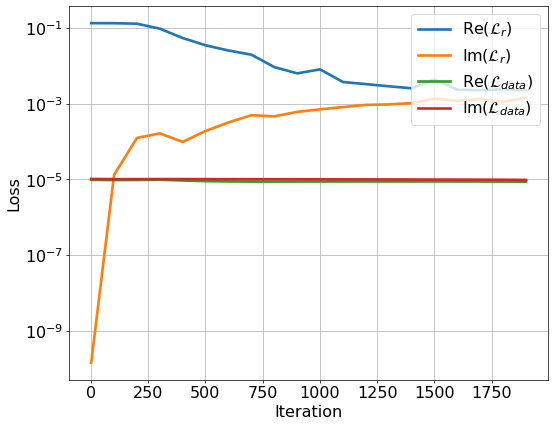

In [ ]:
# loss曲线
loss_logger = np.load("./loss_logger_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(9, 7), dpi=64)
ax = fig.subplots()

k = 100
# ax.plot(loss_logger["iter"][::k], loss_logger["loss"][::k], label=r"$\mathcal{L}$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_res_u"][::k], label=r"Re($\mathcal{L}_{r})$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_res_v"][::k], label=r"Im($\mathcal{L}_{r})$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_data_u"][::k], label=r"Re($\mathcal{L}_{data})$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_data_v"][::k], label=r"Im($\mathcal{L}_{data})$", linewidth=3)
ax.set_yscale('log')
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.grid()

ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('Loss.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
backbone = MLP(mlp_layers)
nn_k = MLP(mlp_layers_k)
pinn = PINNHelmholtz(backbone, nn_k)
pinn = pinn.to(device)
model_state = torch.load(os.path.join(model_path, 'backbone_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_k.load_state_dict(model_state['nn_k_state'])

<All keys matched successfully>

In [ ]:
def func_k(X_res):
    k = np.empty(X_res.shape[0])
    k0_ = k0.item()
    for i in range(X_res.shape[0]):
        x1, x2 = X_res[i]
        if (-0.5 < x1) and (x1 < 0) and (-0.25 < x2) and (x2 < 0.25):
            k[i] = k0_ / 1.5
        else:
            k[i] = k0_
    k = k.reshape(-1, 1)
    return k

In [ ]:
# relative L2 误差
x_test = x[0, 256:-256][::5]
y_test = y[0, 256:-256][::5]

xx, yy = np.meshgrid(x_test, y_test)

uf_test = uf[256:-256, 256:-256]
uf_test = uf_test[::5, ::5]

uu = uf_test.real
vv = uf_test.imag

X = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)

X = torch.from_numpy(X).float().to(device)
uv_pred = pinn.net_u(X).detach().cpu().numpy()

kk_pred = pinn.net_k(X).detach().cpu().numpy().reshape(xx.shape)
kk = func_k(X.detach().cpu().numpy()).reshape(xx.shape)


uu_pred = uv_pred[:, 0].reshape(xx.shape)
vv_pred = uv_pred[:, 1].reshape(xx.shape)

error_u = np.linalg.norm(uu_pred - uu) / np.linalg.norm(uu)
error_v = np.linalg.norm(vv_pred - vv) / np.linalg.norm(vv)
error_k = np.linalg.norm(kk_pred - kk) / np.linalg.norm(kk)
print('u Relative l2 error: {:.3e}'.format(error_u))
print('v Relative l2 error: {:.3e}'.format(error_v))
print('k Relative l2 error: {:.3e}'.format(error_k))

u Relative l2 error: 9.541e-01
v Relative l2 error: 9.730e-01
k Relative l2 error: 1.143e+00


<ipython-input-18-ad8776270d8d>:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(cax)
<ipython-input-18-ad8776270d8d>:16: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar2 = fig.colorbar(cax2)


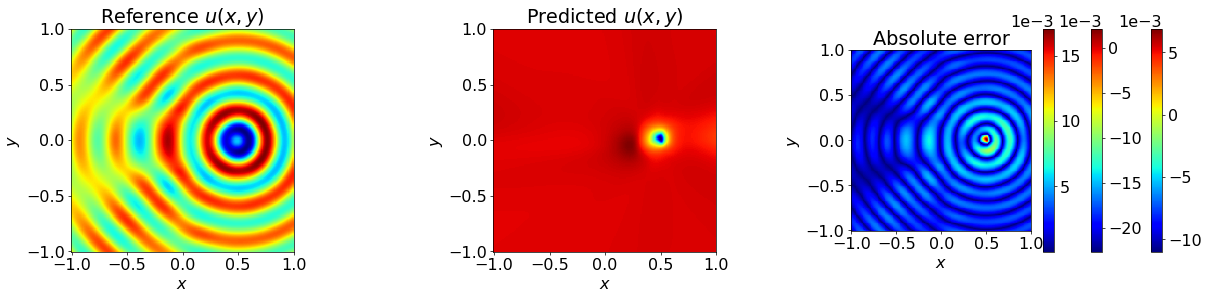

In [ ]:
fig = plt.figure(figsize=(20, 5), dpi=64)
[ax, ax2, ax3] = fig.subplots(1, 3)

cax = ax.pcolor(xx, yy, uu, cmap='jet')
cbar = fig.colorbar(cax)
cbar.formatter.set_powerlimits((-3, -3))
cbar.update_ticks()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $u(x,y)$')
ax.set_xticks(np.linspace(-1, 1, 5))
ax.set_yticks(np.linspace(-1, 1, 5))
ax.set_aspect(1./ax.get_data_ratio())

cax2 = ax2.pcolor(xx, yy, uu_pred, cmap='jet')
cbar2 = fig.colorbar(cax2)
cbar2.formatter.set_powerlimits((-3, -3))
cbar2.update_ticks()
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title(r'Predicted $u(x,y)$')
ax2.set_xticks(np.linspace(-1, 1, 5))
ax2.set_yticks(np.linspace(-1, 1, 5))
ax2.set_aspect(1./ax.get_data_ratio())

cax3 = ax3.pcolor(xx, yy, np.abs(uu - uu_pred), cmap='jet')
cbar3 = fig.colorbar(cax3)
cbar3.formatter.set_powerlimits((-3, -3))
cbar3.update_ticks()
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
ax3.set_title(r'Absolute error')
ax3.set_xticks(np.linspace(-1, 1, 5))
ax3.set_yticks(np.linspace(-1, 1, 5))
ax3.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
plt.savefig('Helmholtz_result_real.png')
plt.show()

<ipython-input-19-dfbe5195ec87>:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(cax)
<ipython-input-19-dfbe5195ec87>:16: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar2 = fig.colorbar(cax2)


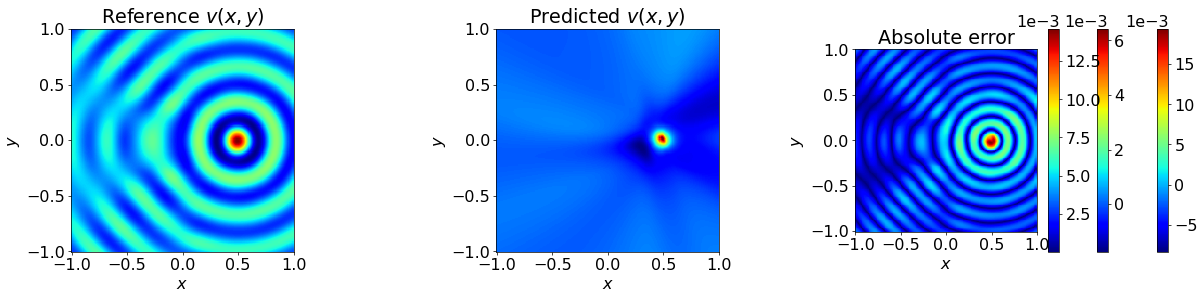

In [ ]:
fig = plt.figure(figsize=(20, 5), dpi=64)
[ax, ax2, ax3] = fig.subplots(1, 3)

cax = ax.pcolor(xx, yy, vv, cmap='jet')
cbar = fig.colorbar(cax)
cbar.formatter.set_powerlimits((-3, -3))
cbar.update_ticks()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $v(x,y)$')
ax.set_xticks(np.linspace(-1, 1, 5))
ax.set_yticks(np.linspace(-1, 1, 5))
ax.set_aspect(1./ax.get_data_ratio())

cax2 = ax2.pcolor(xx, yy, vv_pred, cmap='jet')
cbar2 = fig.colorbar(cax2)
cbar2.formatter.set_powerlimits((-3, -3))
cbar2.update_ticks()
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title(r'Predicted $v(x,y)$')
ax2.set_xticks(np.linspace(-1, 1, 5))
ax2.set_yticks(np.linspace(-1, 1, 5))
ax2.set_aspect(1./ax.get_data_ratio())

cax3 = ax3.pcolor(xx, yy, np.abs(vv - vv_pred), cmap='jet')
cbar3 = fig.colorbar(cax3)
cbar3.formatter.set_powerlimits((-3, -3))
cbar3.update_ticks()
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
ax3.set_title(r'Absolute error')
ax3.set_xticks(np.linspace(-1, 1, 5))
ax3.set_yticks(np.linspace(-1, 1, 5))
ax3.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
plt.savefig('Helmholtz_result_imag.png')
plt.show()


<ipython-input-20-3f2a1c0ce6af>:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(cax)
<ipython-input-20-3f2a1c0ce6af>:14: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar2 = fig.colorbar(cax2)


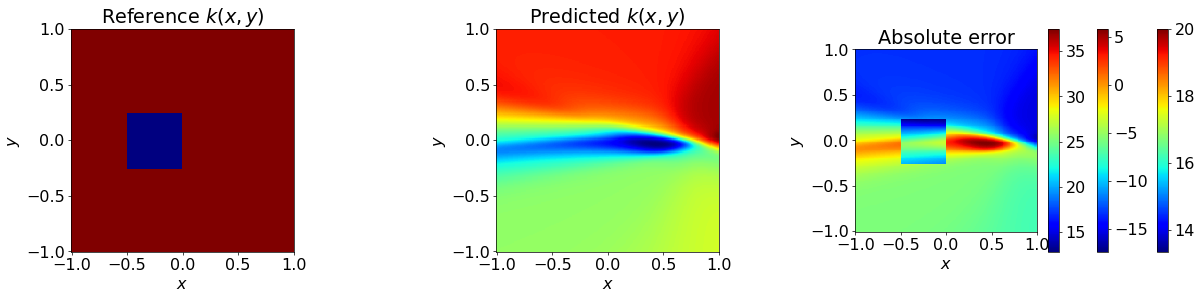

In [ ]:
fig = plt.figure(figsize=(20, 5), dpi=64)
[ax, ax2, ax3] = fig.subplots(1, 3)

cax = ax.pcolor(xx, yy, kk, cmap='jet')
cbar = fig.colorbar(cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'Reference $k(x,y)$')
ax.set_xticks(np.linspace(-1, 1, 5))
ax.set_yticks(np.linspace(-1, 1, 5))
ax.set_aspect(1./ax.get_data_ratio())

cax2 = ax2.pcolor(xx, yy, kk_pred, cmap='jet')
cbar2 = fig.colorbar(cax2)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title(r'Predicted $k(x,y)$')
ax2.set_xticks(np.linspace(-1, 1, 5))
ax2.set_yticks(np.linspace(-1, 1, 5))
ax2.set_aspect(1./ax.get_data_ratio())

cax3 = ax3.pcolor(xx, yy, np.abs(kk - kk_pred), cmap='jet')
cbar3 = fig.colorbar(cax3)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
ax3.set_title(r'Absolute error')
ax3.set_xticks(np.linspace(-1, 1, 5))
ax3.set_yticks(np.linspace(-1, 1, 5))
ax3.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
plt.savefig('Helmholtz_result_k.png')
plt.show()